# GANs

Training GAN to produce data from a bivaritate normal.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns # for pretty plots
from scipy.stats import norm
from scipy.stats import multivariate_normal as mn

In [7]:
#Auxiliary functions:
def countour_plot(dataDist, range_min = -1, range_max = 3, delta = 0.025, cmap_par = 'gray'):
    x = y = np.arange(range_min, range_max, delta)
    X, Y = np.meshgrid(x, y)
    Z = X.copy()
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = dataDist.pdf([X[i,j],Y[i,j]])
    plt.figure()
    CS = plt.contour(X, Y, Z, cmap = cmap_par)
    #plt.clabel(CS, inline=1, fontsize=10)



def plot_fig(r,M,cmap_par = 'Greys'):
    # plots pg, pdata, decision boundary
    countour_plot(dataDist = xDist, range_min = -1, range_max = 3, delta = 0.025, cmap_par = cmap_par)
    # distribution of inverse-mapped points

    z=zDist.rvs(r)
    gs=np.zeros((r,2)) # generator function
    for i in range(int(r/M)):
        z=zDist.rvs(M)
        gs[M*i:M*(i+1),:]=sess.run(G,{z_node: z})
    plt.scatter(gs[:,0], gs[:,1], label='p_g', alpha = 0.3)

    
#Optimizers:
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

def grad_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.03,
        batch,
        150,
        0.95,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

def adam_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        learning_rate = 0.001,
        global_step = batch,
        decay_steps = 250,
        decay_rate = 0.95,
        staircase=True
    )
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer


In [8]:
##Network architecture:

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

mu = [1,1]
Rho = np.diag([1.0,1.0]); Rho[0,1] = Rho[1,0] = 0.5
Sd = np.diag([0.7,0.7])
Sigma = Sd@Rho@Sd

xDist = mn(mu, Sigma)
zDist = mn([0,0], np.eye(2))

# MLP - used for D_pre, D1, D2, G networks
def linear(input, output_dim, scope = None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

def generator(input, h_dim):
    h0 = tf.nn.softplus(linear(input, h_dim, 'g0'))
    h1 = tf.nn.softplus(linear(h0, h_dim, 'g1'))
    h2 = linear(h1, 2, 'g2')
    return h2

def discriminator(input, h_dim, minibatch_layer=False):
    h0 = tf.nn.tanh(linear(input, h_dim * 2, 'd0'))
    h1 = tf.nn.tanh(linear(h0, h_dim * 2, 'd1'))
    # without the minibatch layer, the discriminator needs an additional layer
    # to have enough capacity to separate the two distributions correctly
    if minibatch_layer:
        h2 = minibatch(h1)
    else:
        h2 = tf.nn.tanh(linear(h1, h_dim * 2, 'd2'))
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

def minibatch(input, num_kernels=5, kernel_dim=3):
    x = linear(input, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    return tf.concat([input, minibatch_features], 1)



In [9]:
#Pre-train Decision Surface (Discriminator??)
hidden_size = 20
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(None,2))
    train_labels=tf.placeholder(tf.float32,shape=(None,1))
    D = discriminator(input_node, hidden_size)
    loss=tf.reduce_mean(tf.norm(D-train_labels)) #Loss is difference bet. GAN output and Gauss Density!

#optimizer=momentum_optimizer(loss,None)
#optimizer = grad_optimizer(loss, None)
optimizer = adam_optimizer(loss, None)


# BUILD NETWORK
##Neural Network for the generator:
with tf.variable_scope("Gen"):
    z_node=tf.placeholder(tf.float32, shape=(None,2)) # M uniform01 floats
    G=generator(z_node,hidden_size) # generate normal transformation of Z

##Neural network for the Discriminator:
with tf.variable_scope("Disc") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(None,2)) # input M normally distributed floats
    D1=discriminator(x_node,hidden_size) # output likelihood of being normally distributed
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()#Variables in scope D are reused.
    D2=discriminator(G,hidden_size) #G is the output of a graph in a different scope.


In [11]:
#Objective function:

obj_d=tf.reduce_mean(-tf.log(D1)-tf.log(1-D2))
obj_g=tf.reduce_mean(-tf.log(D2))

# copy weights from pre-training over to new D network.
d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')

# set up optimizer for G,D
opt_d=grad_optimizer(obj_d, d_params)
#opt_g=grad_optimizer(obj_g, g_params) # maximize log(D(G(z)))
opt_g=adam_optimizer(obj_g, g_params) # maximize log(D(G(z)))



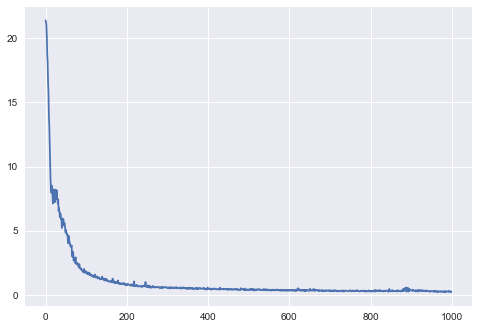

In [12]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

# process multiple points in parallel in a minibatch
M = 1000
lh=np.zeros(M)
for i in range(M):
    d=xDist.rvs(M)#pData sample
    labels=xDist.pdf(d)
    lh[i],_=sess.run([loss,optimizer], {input_node: d, train_labels: np.reshape(labels,(M,1))})

# pre-training Parameters:
weightsD = sess.run(d_pre_params)

plt.plot(lh)
plt.show()


0.0 4.72244548798 6.68704843521
0.1 1.07775366306 2.38591718674
0.2 1.32985448837 0.866855323315
0.3 1.35371875763 0.761915385723
0.4 1.37713181973 0.731237709522
0.5 1.38842141628 0.712827801704
0.6 1.38151097298 0.720953285694
0.7 1.38625121117 0.683052957058
0.8 1.39613699913 0.668190717697
0.9 1.35162210464 0.701678454876


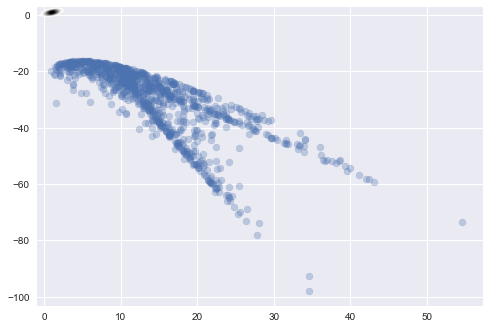

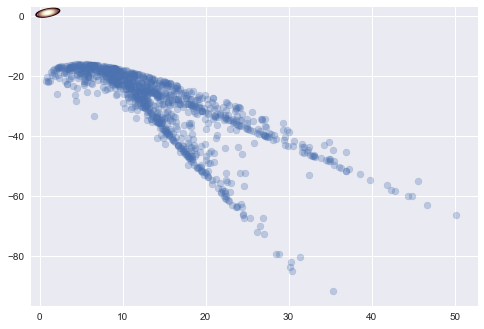

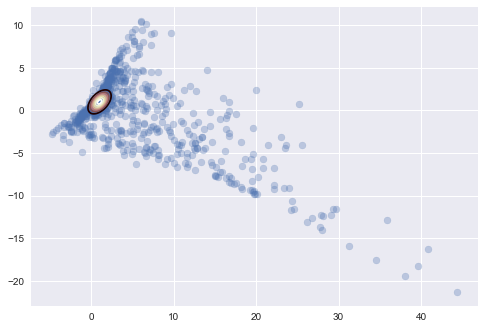

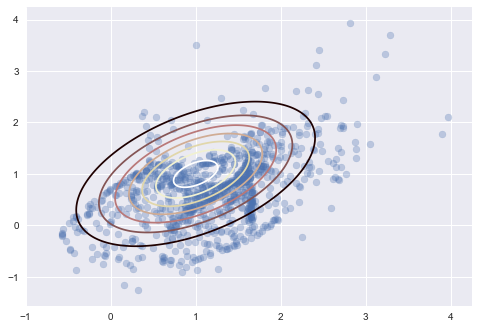

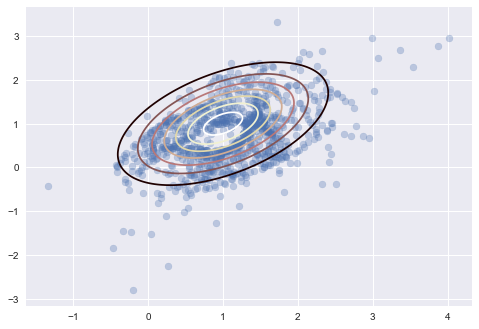

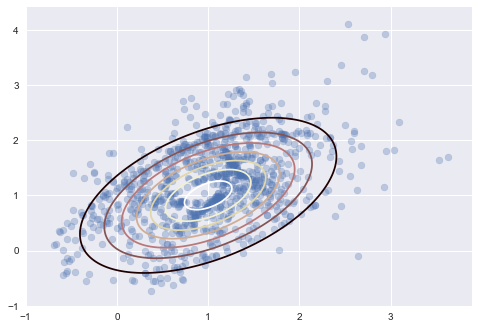

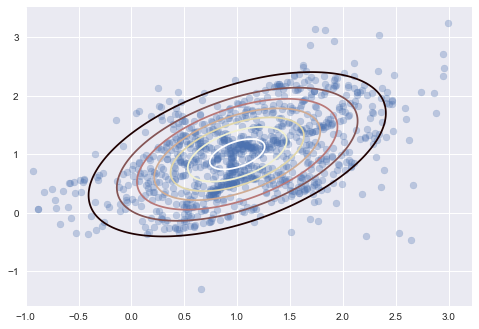

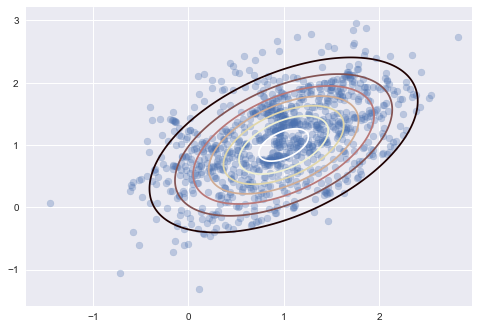

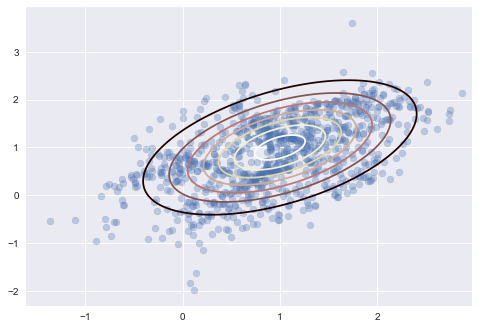

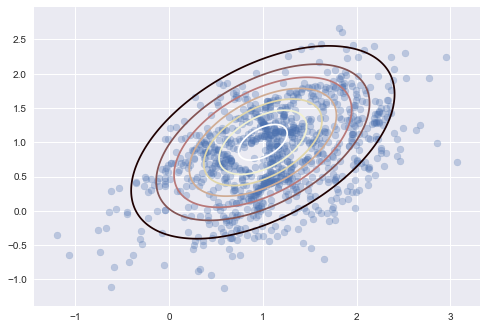

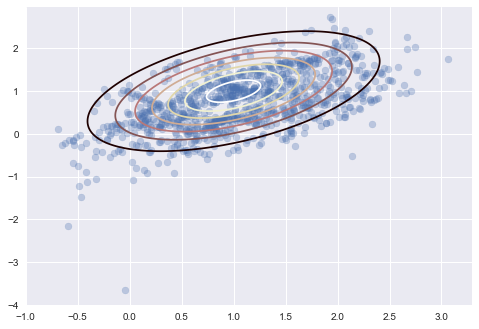

In [13]:
for i, v in enumerate(d_params):
    sess.run(v.assign(weightsD[i]))

# initial conditions
# Algorithm 1 of Goodfellow et al 2014
k=1 #Times we train the discriminator for each run of the generator.
M=1000
TRAIN_ITERS = 10000
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
#histd and histf save the history of the loss for the discriminator and the generator.
plot_fig(r = 1000, M = 1000) #Plot before training
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= xDist.rvs(M) # sampled m-batch from p_data
        z= zDist.rvs(M)
        histd[i],_=sess.run([obj_d, opt_d], {x_node: x, z_node: z})
    z= zDist.rvs(M)
    histg[i],_=sess.run([obj_g,opt_g], {z_node: z}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        plot_fig(r = 1000, M = 1000, cmap_par = 'pink')
        #plt.title('Training interations: %d' % i)
        print(float(i)/float(TRAIN_ITERS), histd[i], histg[i])

for i in plt.get_fignums():
    plt.figure(i)
    #n_iter = i*1000
    #plt.title('Training interations: %d' % n_iter)
    #plt.savefig('../thesis/images/fig_biv%d.png' % i)

plt.show()
    

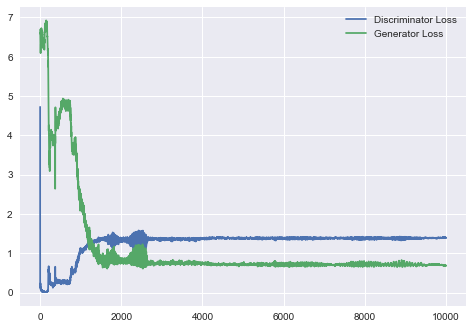

In [14]:
plt.plot(range(TRAIN_ITERS),histd, label='Discriminator Loss')
plt.plot(range(TRAIN_ITERS), histg, label='Generator Loss')
plt.legend()
plt.savefig('../thesis/images/loss_biv.png')
plt.show()


sess.close()
